# Traffic Light Detection In Oriented Imagery Using Triangulation

> * 🔬 Data Science
> * 🥠 Deep Learning and Object Classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Download & setup data](#Download-&-setup-data)
* [Model training](#Model-training)
* [Model inferencing](#Model-inferencing)
* [Extract location of traffic lights on map using Triangulation](#Extract-location-of-traffic-lights-on-map-using-Triangulation)
* [Results](#Results)
* [Exporting the output](#Exporting-the-output)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

Generally, object detection is applied on images taken looking straight down at the ground, like in traditional satellite imagery, predictions from which can be visualized on a map and incorporated into your GIS. Other imagery, however, is more difficult to visualize and incorporate into your GIS. Such non-nadir oriented imagery includes oblique, bubble, 360-degree, street-side, and inspection imagery, among others. Through this sample, we will demonstrate the utility of an object detection model for detecting objects in oriented imagery using `ArcGIS API for Python`.

The `arcgis.learn` module supports a number of object detection models, such as `SingleShotDetector`, `RetinaNet`, `FasterRCNN`, `YoloV3`, and more. In this notebook, we will be using the YoloV3 model for detecting traffic lights in oriented imagery. The biggest advantage of `YOLOv3` in `arcgis.learn`, is that it comes preloaded with weights pretrained on the [COCO dataset](https://cocodataset.org/#home). This makes it ready-to-use for the 80 common objects (car, truck, person, etc.) that are part of the COCO dataset. Using this model, we will detect traffic lights in oriented imagery.

## Necessary imports

In [1]:
import os, json, cv2
from math import *
import numpy as np
import itertools
import pandas as pd
import zipfile
from pathlib import Path

In [2]:
from arcgis import GIS
from arcgis.geometry import Point,Geometry
from arcgis.learn import YOLOv3

## Download & setup data

For this notebook, we will use sample oriented imagery and oriented imagery meta data files, available on ArcGIS Online, for inferencing and plotting points.

In [4]:
gis = GIS("home")

In [5]:
# Sample data can be directly downloded by clickng on the link below
oriented_imagery_data = gis.content.get("d606e6827c8746e383de96d8718be9a8") 
oriented_imagery_data

<Item title:"Oriented Imagery Sample Data" type:Image Collection owner:api_data_owner>

In [6]:
filepath = oriented_imagery_data.download(save_path = os.getcwd(), file_name=oriented_imagery_data.name)

<IPython.core.display.Javascript object>

In [7]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

After extracting the zip file, we will set the path of the items in the zip file.
- `data_path`: Folder containing all the oriented imagery.
- `image_meta_data` : File containing meta data for all the oriented images in the `data_path`.


In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]), "street_view_data")
image_meta_data = Path(os.path.join(os.path.splitext(filepath)[0]), "oriented_imagery_meta_data.csv")

<IPython.core.display.Javascript object>

In [8]:
image_path_list = [os.path.join(data_path, image) for image in os.listdir(data_path)]

<IPython.core.display.Javascript object>

## Model training

Since we are using the pretrained `YOLOv3` model, we will pass the `pretrained_backbone` attribute as `True`. This will download the pre trained weights of the `YOLOv3` model with COCO dataset while the `YOLOv3` model is initializing. We will use these weights later to detect traffic lights.

In [9]:
yolo = YOLOv3(pretrained_backbone=True)

<IPython.core.display.Javascript object>

## Model inferencing

Once the model is loaded and ready for inferencing, we will create a function named `traffic_light_finder` that will take oriented imagery as input and will return the following:
- `Json` containing traffic lights coordinates
- Traffic lights annotated image

We will save all the traffic lights annotated image into a folder named <b>traffic_light_marked</b> and save all the annotations in a combined `json` file on the disk.

In [10]:
def traffic_light_finder(oriented_image_path):
    flag = 0
    coordlist = []
    temp_list = {}
    out = yolo.predict(
        oriented_image_path, threshold=0.5, batch_size=4
    )  # Depending upon your GPU capability, batch_size number can be changed.
    test_img = cv2.imread(oriented_image_path)
    if len(out[0]) == 0:
        temp_list["object"] = False
    else:
        for index, (value, label, confidence) in enumerate(zip(out[0], out[1], out[2])):
            if label == "traffic light":
                flag = 1
                coordlist.append(
                    [int(value[0]), int(value[1]), int(value[2]), int(value[3])]
                )
                test_img = cv2.rectangle(
                    test_img,
                    (int(value[0]), int(value[1]), int(value[2]), int(value[3])),
                    (0, 0, 255),
                    10,
                )
                textvalue = label + "_" + str(confidence)
                cv2.putText(
                    test_img,
                    textvalue,
                    (int(value[0]), int(value[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    (0, 0, 255),
                    2,
                )
        if flag == 1:
            temp_list["object"] = True
            temp_list["coords"] = coordlist
            temp_list["assetname"] = "traffic light"
    return temp_list, test_img


<IPython.core.display.Javascript object>

Here we will create a folder named <b>traffic_light_marked</b> that will contain the images with detected traffic lights. We can use these images to check the output of the model, and later for our use case.

In [7]:
marked_image_saved_folder = os.path.join(os.getcwd(), "traffic_light_marked")
os.makedirs(marked_image_saved_folder, exist_ok=True)
print("Path created for saving the images with traffic light detected on them : - ", marked_image_saved_folder)

Path created for saving the images with traffic light detected on them : -  C:\Users\roh12004\Documents\arcgis-python-api\samples\04_gis_analysts_data_scientists\traffic_light_marked


In [ ]:
detections = {}
for e, image in enumerate(image_path_list):
    try:
        val_dict, out_image = traffic_light_finder(image)
        if bool(val_dict):
            detections[os.path.basename(image)] = val_dict
            cv2.imwrite(os.path.join(marked_image_saved_folder, os.path.basename(image)), out_image)
    except Exception as e:
        print(e)

Here, we are also saving the coordinates of the traffic lights in a `json` file. We can use these coordinates to create a web map or for other use cases.

In [14]:
with open("traffic_light_data_sample.json", "w") as f:
    json.dump(detections, f)

<IPython.core.display.Javascript object>

Below are some of the images showcasing how the pretrained `YOLOv3` model performs on the oriented imagery. 

<img src="../../static/img/oriented_image_yolo_output.gif" width="750" align="center">

## Extract location of traffic lights on map using Triangulation

We have successfully ran the `YOLOv3` pretrained model on the oriented imagery and generated the coordinates of the detected traffic lights.

We also created an oriented image meta data CSV file (downloaded above) that contains the meta data of the oriented imagery, such as the coordinates of the image, <b>AvgHtAG</b>, <b>CamHeading</b>, <b>CamOri</b>, <b>HFOV</b>, <b>VFOV</b> etc. You can learn more about these data points from this [document](https://www.esri.com/content/dam/esrisites/en-us/about/events/media/UC-2019/technical-workshops/tw-5765-872.pdf).

Using this data, we will now try to find the exact location of the traffic lights on the map.

In [26]:
camera_df = pd.read_csv(image_meta_data)
camera_df.head()

Unnamed: 0  AcquisitionDate  AvgHtAG  CamHeading  \
0           0              NaN      2.5   320.86540   
1           1              NaN      2.5   358.02590   
2           2              NaN      2.5     6.04420   
3           3              NaN      2.5     6.31495   
4           4              NaN      2.5     6.27997   

                                              CamOri  CamPitch  CamRoll  \
0  3|3346||582715.827|6063651.438|111.212|-38.134...  88.64669 -1.58360   
1  3|3346||582717.142|6063646.62|111.26|-0.97405|...  88.97281 -2.20641   
2  3|3346||582716.637|6063641.632|111.262|7.0442|...  88.89201 -3.11810   
3  3|3346||582716.017|6063636.642|111.284|7.31495...  88.85389 -3.14057   
4  3|3346||582715.377|6063631.674|111.302|7.27997...  88.77918 -3.34327   

   FarDist   HFOV                                              Image  \
0     50.0  360.0  https://orientedimagerysamples.s3.amazonaws.co...   
1     50.0  360.0  https://orientedimagerysamples.s3.amazonaws.co...   
2     50.0  360.0  https://orientedimagerysamples.s3.amazonaws.co...   
3     50.0  360.0  https://orientedimagerysamples.s3.amazonaws.co...   
4     50.0  360.0  https://orientedimagerysamples.s3.amazonaws.co...   

                 Name  NearDist  OBJECTID OIType  \
0  pano_000050_000371       1.0     26716      B   
1  pano_000050_000372       1.0     26717      B   
2  pano_000050_000373       1.0     26718      B   
3  pano_000050_000374       1.0     26719      B   
4  pano_000050_000375       1.0     26720      B   

                                               SHAPE   VFOV  
0  {'x': 2814531.6957999994, 'y': 7304332.8588000...  180.0  
1  {'x': 2814533.810899999, 'y': 7304324.47829999...  180.0  
2  {'x': 2814532.786800001, 'y': 7304315.84749999...  180.0  
3  {'x': 2814531.5621999986, 'y': 7304307.2359, '...  180.0  
4  {'x': 2814530.293200001, 'y': 7304298.6629, 's...  180.0

In [27]:
dets = list(detections.keys())

In [28]:
def find_intersection(
    x1,
    y1,
    x2,
    y2,
    x3,
    y3,
    x4,
    y4,
):
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )
    return [px, py]


def ccw(A, B, C):
    return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)


def intersect(A, B, C, D):
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)


class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def process(input_list, threshold=(10, 15)):
    combos = itertools.combinations(input_list, 2)
    points_to_remove = [
        point2
        for (point1, point2) in combos
        if abs(point1[0] - point2[0]) <= threshold[0]
        and abs(point1[1] - point2[1]) <= threshold[1]
    ]
    points_to_keep = [point for point in input_list if point not in points_to_remove]
    return points_to_keep


In [ ]:
(H, W, _) = cv2.imread(image_path_list[0]).shape
points = []
meta_data= []

for i in range(len(dets) - 1):  # check coordinates of two consecutive images
    # load data of image1
    img1 = (dets[i])[:-4]
    cam1 = camera_df[camera_df["Name"] == img1].to_dict("records")[0]
    bboxes1 = detections[img1 + ".jpg"]["coords"]

    # load data of image2

    img2 = (dets[i + 1])[:-4]
    cam2 = camera_df[camera_df["Name"] == img2].to_dict("records")[0]
    bboxes2 = detections[img2 + ".jpg"]["coords"]

    DIST = cam1["FarDist"]

    for bbox1 in bboxes1:  # loop over all the bbox in image1
        if bbox1[3] > 50:  # ignore small bboxes
            
            x1_0 = eval(cam1["SHAPE"])["x"]
            y1_0 = eval(cam1["SHAPE"])["y"]
            
            # calculate the angle of the object in image1
            direction_angle1 = cam1["CamHeading"] + cam1["HFOV"] / 2.0 * (
                (bbox1[0] + bbox1[2] / 2) - W / 2.0
            ) / (W / 2.0)
            angle_subtended_by_object1 = cam1["VFOV"] * bbox1[3] / H
            
            # calculate the distance where the object is based on angle
            x1_1 = eval(cam1["SHAPE"])["x"] + DIST * cos(
                pi / 2 - radians(direction_angle1)
            )
            y1_1 = eval(cam1["SHAPE"])["y"] + DIST * sin(
                pi / 2 - radians(direction_angle1)
            )

            for bbox2 in bboxes2:  # loop over all the bbox in image2
                if bbox2[3] > 50:  # ignore small bboxes

                    x2_0 = eval(cam2["SHAPE"])["x"]
                    y2_0 = eval(cam2["SHAPE"])["y"]
                    
                    # calculate the angle of the object in image2
                    direction_angle2 = cam2["CamHeading"] + cam2["HFOV"] / 2.0 * (
                        bbox2[0] + bbox2[2] / 2 - W / 2.0
                    ) / (W / 2.0)
                    angle_subtended_by_object2 = cam2["VFOV"] * bbox2[3] / H
                    
                    # calculate the distance where the object is based on angle
                    x2_1 = eval(cam2["SHAPE"])["x"] + DIST * cos(
                        pi / 2 - radians(direction_angle2)
                    )
                    y2_1 = eval(cam2["SHAPE"])["y"] + DIST * sin(
                        pi / 2 - radians(direction_angle2)
                    )
                    
                    # find if the line intersects
                    val = intersect(
                        dotdict({"x": x1_0, "y": y1_0}),
                        dotdict({"x": x1_1, "y": y1_1}),
                        dotdict({"x": x2_0, "y": y2_0}),
                        dotdict({"x": x2_1, "y": y2_1}),
                    )
                    xmin, ymin, xmax, ymax = (
                        bbox2[0],
                        bbox2[1],
                        bbox2[0] + bbox2[2],
                        bbox2[1] + bbox2[3],
                    )
                    
                    # find the point where line from image1 and image2 intersect
                    if val:
                        midpoint = find_intersection(
                            x1_0, y1_0, x1_1, y1_1, x2_0, y2_0, x2_1, y2_1
                        )
                        points.append(midpoint)
                        meta_data.append(
                            {
                                "image1": img1,
                                "image2": img2,
                                "points": midpoint,
                                "coords": [xmin, ymin, xmax, ymax],
                                "x": midpoint[0],
                                "y": midpoint[1],
                            }
                        )


After the above mentioned process we have got some coordinates where there will be traffic lights but as one traffic light can be detected in multiple images therefore we will further cluster the data and take only one traffic light from a cluster.

In this way we will remove the redundant traffic light near a point.

In [36]:
print 'Number of traffic lights extracted - {}'.format(len(points))
outpoints = process(points)
print 'Number of traffic lights extracted after clustering and removing redundant traffic light - {}'.format(len(outpoints))

Number of traffic lights extracted - 302
Number of traffic lights extracted after clustering and removing redundant traffic light - 40


## Results 

Next, we will load a map and draw the final selected traffic light coordinates on it.


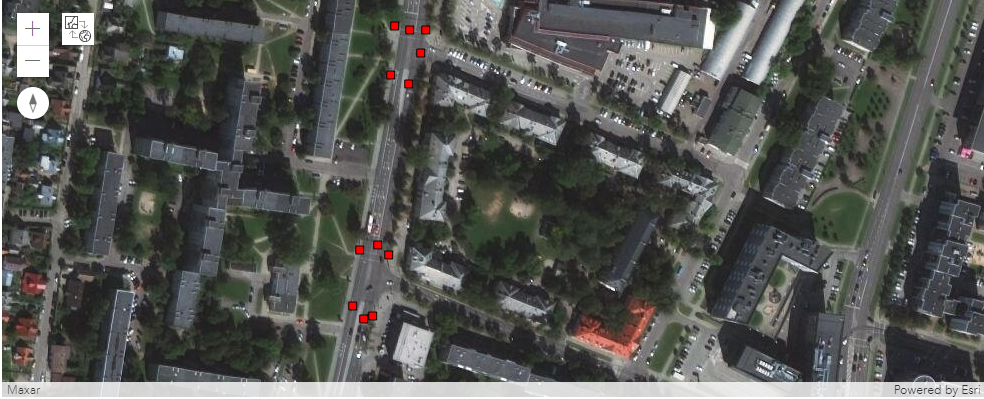

In [3]:
m = gis.map('Vilnius City')
m

In [ ]:
m.center = {'x': 25.28489583988743, 'y': 54.70681816057357,
            'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}
m.zoom = 19
m.basemap = 'satellite'

In [ ]:
for point in outpoints:
    intpoint = {'x': point[0], 'y': point[1],
                'spatialReference': {'wkid': 102100,
                'latestWkid': 3857}}
    m.draw(arcgis.geometry.Point(intpoint), symbol={
        'type': 'simple-marker',
        'style': 'square',
        'color': 'red',
        'size': '8px',
        })

## Exporting the output 

In [ ]:
out_meta_data = []
for e,i in enumerate(points):
    if i in outpoints:
        out_meta_data.append(meta_data[e])

In [ ]:
# creating a spatial dataframe and exporting as feature class
spatial_df = []
for e, i in enumerate(out_meta_data):
    tempdict = {}
    tempdict["X"] = i["x"]
    tempdict["Y"] = i["y"]
    tempdict["Z"] = 100
    tempdict["ImgUrn"] = str(
        i["image2"][1:]
        + "|VilniusCity_ExposurePoints|"
        + str(
            camera_df[camera_df["Name"] == i["image2"]].to_dict("records")[0][
                "OBJECTID"
            ]
        )
    )
    tempdict["ImgGeom"] = json.dumps(
        {
            "xmin": i["coords"][0],
            "ymin": i["coords"][1],
            "xmax": i["coords"][2],
            "ymax": i["coords"][3],
            "pos": "BC",
        }
    )
    tempdict["Labels"] = "traffic lights"
    tempdict["SHAPE"] = Geometry(
        {
            "x": i["x"],
            "y": i["y"],
            "spatialReference": {"wkid": 3857, "latestWkid": 102100},
        }
    )
    spatial_df.append(tempdict)

    
df = pd.DataFrame(data=spatial_df)
df.spatial.set_geometry("SHAPE")

# exporting the layer on ArcGIS Online org
exported_layer = df.spatial.to_featurelayer(r"exported_traffic_points", sanitize_columns=False,gis=gis)

## Conclusion 

In this notebook, we performed object detection on oriented imagery. We used the `YoloV3` model with pretrained weights for detecting traffic lights, located these on the gis map using `ArcGIS API for Python`, and exported the output as a feature class.

## References 

[1] [Managing and visualizing oriented imagery](https://doc.arcgis.com/en/imagery/workflows/resources/managing-and-visualizing-oriented-imagery.htm)

[2] [YOLOv3 Object Detector](https://developers.arcgis.com/python/guide/yolov3-object-detector/)

[3] [Working with Oriented Imagery](https://www.esri.com/content/dam/esrisites/en-us/about/events/media/UC-2019/technical-workshops/tw-5765-872.pdf)